# Business Case: Netflix - Data Exploration and Visualisation
## Context
Netflix is one of the most popular media and video streaming platforms. They have over 10000 movies or tv shows available on their platform, as of mid-2021, they have over 222M Subscribers globally. This tabular dataset consists of listings of all the movies and tv shows available on Netflix, along with details such as - cast, directors, ratings, release year, duration, etc.

## 1. Problem Statement & Basic metrics
### 1.1 Problem
Analyze the data and generate insights that could help Netflix in deciding which type of shows/movies to produce and how they can grow the business in different countries

In [1]:
# data:
# !wget -nc https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/000/940/original/netflix.csv -O ../temp/netflix.csv

### 1.2 Shape of data
Import the dataset and do usual exploratory data analysis steps like checking the structure & characteristics of the dataset

In [2]:
import pandas as pd
df = pd.read_csv('../temp/netflix.csv')
df.shape

(8807, 12)

We have 8807 records with 12 features

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


* show_id can be index 
* type, director, country, rating can be categories
* date_added, duration can be numerical variables
* title, director, cast, listed_in, description can be text 

In [4]:
# categorical variables
cast = {
    'type': 'category',
    # 'director': 'category',
    'country': 'category',
    'rating': 'category'
}

# Numerical variables
df_cast = df.astype(cast)
df_cast['date_added'] = pd.to_datetime(df['date_added'].str.strip(), format='%B %d, %Y', errors='raise')

duration_int = df['duration'].str.split().apply(lambda x: x[0] if type(x)==list else x)
df_cast['duration'] = duration_int.astype(dtype=pd.Int32Dtype())

# index
df_cast.set_index('show_id', inplace=True)

### 1.3 Missing Value detection

* director column has 2.6k missing values
* cast and country have around 800+ missing values

In [5]:
df_cast.isna().sum()

type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

## 2. Value counts and unique attributes

In [6]:
# number of unique values for each column
df_cast.apply(lambda c: c.nunique(), axis=0)

type               2
title           8807
director        4528
cast            7692
country          748
date_added      1714
release_year      74
rating            17
duration         210
listed_in        514
description     8775
dtype: int64

In [7]:
PRNT_MAX_LEN = 25

def print_value_counts(df: pd.DataFrame, cols:str):
    
    texts = {
        col: df[col]
            .apply(lambda x: (x[:PRNT_MAX_LEN]+'...' if len(x) > PRNT_MAX_LEN else x) if type(x)==str else x)
            .value_counts()
            .to_string()
            .split('\n') 
        for col in cols
    }

    df_texts = pd.DataFrame.from_dict(texts, orient='index').T
    
    for c in cols:
        new_cols = df_texts.columns.to_list()
        df_texts.insert(new_cols.index(c)+1, '|', '|', allow_duplicates=True)
        
    text = df_texts.fillna('').to_string(index=False, header=False)
    print(text)

print_value_counts(df_cast, ['type', 'rating', 'release_year', 'country'])

           type |           rating | release_year |                              country |
Movie      6131 | TV-MA       3207 | 2018    1147 | United States                   2818 |
TV Show    2676 | TV-14       2160 | 2017    1032 | India                            972 |
                | TV-PG        863 | 2019    1030 | United Kingdom                   419 |
                | R            799 | 2020     953 | Japan                            245 |
                | PG-13        490 | 2016     902 | South Korea                      199 |
                | TV-Y7        334 | 2021     592 | Canada                           181 |
                | TV-Y         307 | 2015     560 | Spain                            145 |
                | PG           287 | 2014     352 | France                           124 |
                | TV-G         220 | 2013     288 | Mexico                           110 |
                | NR            80 | 2012     237 | Egypt                            106 |

## 3. Visual Analysis
### 3.1 Univariate Analysis
#### 3.1.1 Type of show

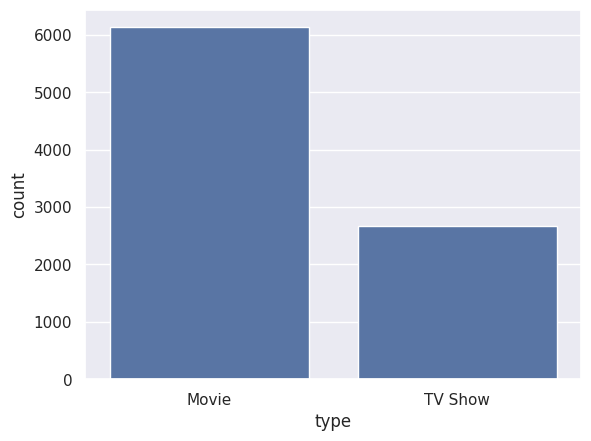

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

ax = sns.countplot(data=df_cast, x='type')
plt.show()

#### 3.1.2 duration (TV Shows)

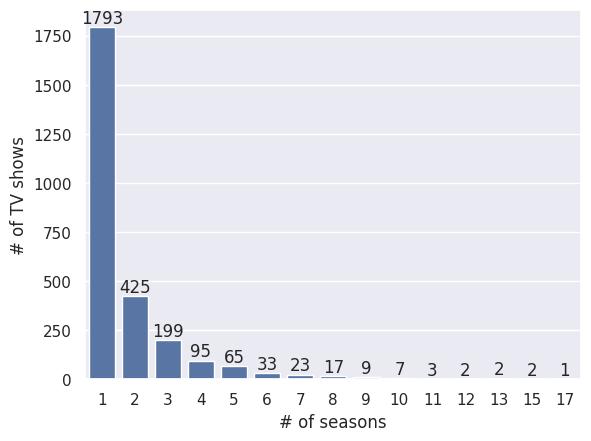

In [9]:
df_tv = df_cast[df_cast['type']=='TV Show']
ax = sns.countplot(data=df_tv, x='duration')
ax.bar_label(ax.containers[0], df_tv['duration'].value_counts().values)
ax.set_xlabel('# of seasons')
ax.set_ylabel('# of TV shows')
plt.show()

#### 3.1.3 duration (Movies)

In [1]:
df_mv = df_cast[df_cast['type']=='Movie']
ax = sns.histplot(data=df_mv, x='duration', kde=True)
# ax.bar_label(ax.containers[0], df_tv['duration'].value_counts().values)
ax.set_xlabel('Duration (minutes)')
ax.set_ylabel('# of Movies')
plt.show()

NameError: name 'df_cast' is not defined

#### 3.1.4 Rating

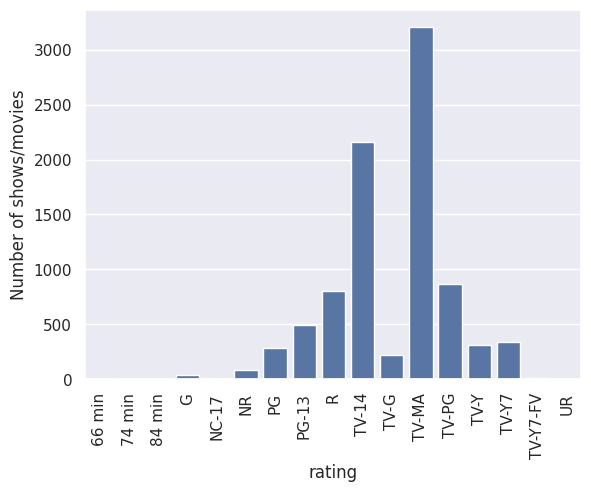

In [11]:
ax = sns.countplot(data=df_cast, x='rating')
ax.set_ylabel('Number of shows/movies')
plt.xticks(rotation=90)
plt.show()

#### 3.1.5 Country

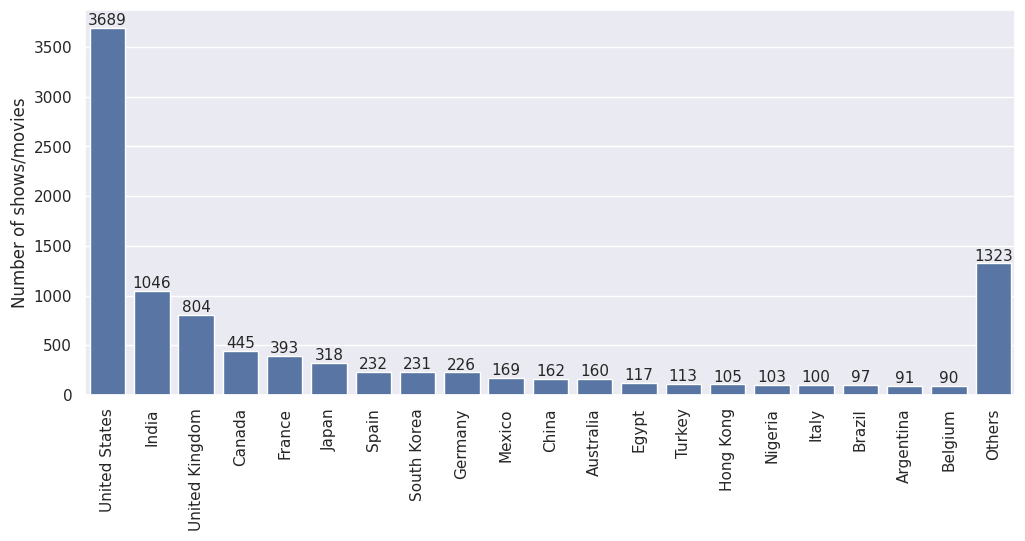

In [61]:
country_count = pd.Series(
    df['country']
    .str.split(', ')
    .apply(lambda x: x if type(x)==list else [])
    .sum()
).value_counts()

TOP = 20
country_top = country_count.head(TOP)
country_top.loc['Others'] = country_count[TOP:].sum()

f, ax = plt.subplots(figsize=(12, 5))
sns.barplot(country_top, ax=ax)
ax.bar_label(ax.containers[0], country_top.values[:TOP], fontsize=11)
ax.set_ylabel('Number of shows/movies')
plt.xticks(rotation=90)
plt.show()

Date Added:

<Axes: xlabel='date_added', ylabel='Count'>

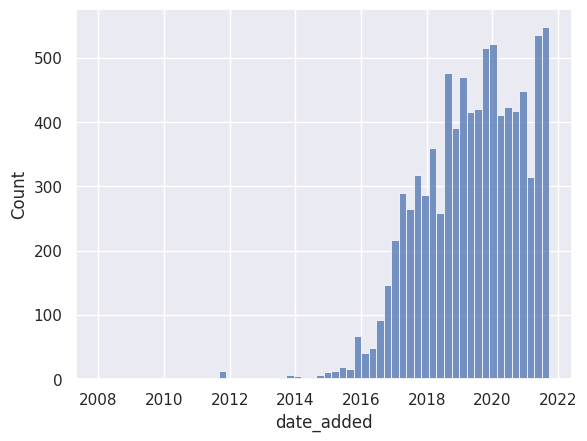

In [64]:
sns.histplot(df_cast['date_added'])

#### 3.1.6 Release Year

<Axes: xlabel='release_year', ylabel='Count'>

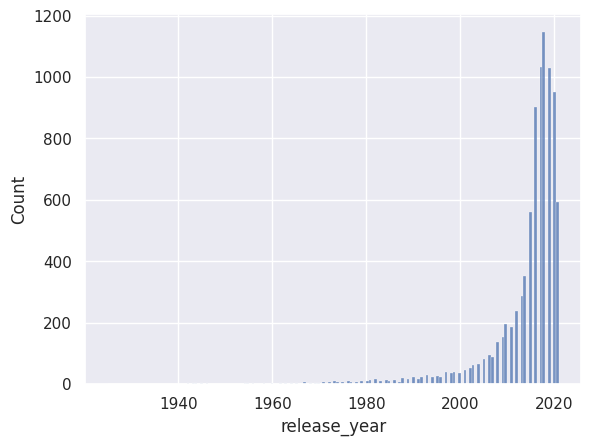

In [65]:
sns.histplot(df_cast['release_year'])

#### 3.1.7 Listed in

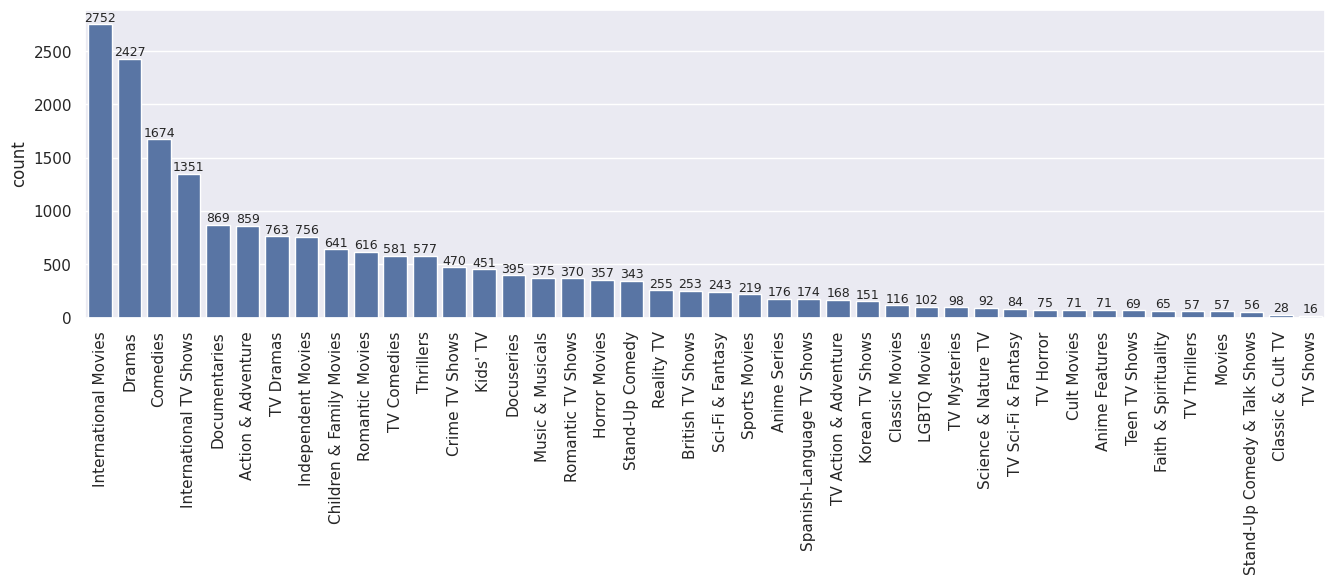

In [84]:
geners_vc = pd.Series(df_cast['listed_in'].str.split(', ').sum()).value_counts()

f, ax = plt.subplots(figsize=(16, 4))
sns.barplot(geners_vc, ax=ax)
ax.bar_label(ax.containers[0], geners_vc.values, fontsize=9)

plt.xticks(rotation=90)
plt.show()